---
# Crop-recommendation
## Features (Inputs):
1. **N – Nitrogen content in the soil (in mg/kg)**
2. **P – phosphorus content in the soil (in mg/kg)**
3. **K – Potassium content in the soil (in mg/kg)**
4. **temperature – Average temperature in °C**
5. **humidity – Average relative humidity in %**
6. **ph – Soil ph value**
7. **rainfall – Rainfall in mm**
8. **Label (Output):**

### **label – The crop most suited to the given conditions (e.g., rice, maize, cotton, etc.)**

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

# Pre-processing tools
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
%matplotlib inline

In [2]:
def outlier_percentage(df):
    percentages = {}
    for col in df.select_dtypes(include=['number']).columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        percentage = (len(outliers) / len(df)) * 100
        percentages[col] = round(percentage, 2)
    
    # Sorting dictionary by percentage in descending order
    sorted_percentages = dict(sorted(percentages.items(), key=lambda item: item[1], reverse=True))

    return sorted_percentages

In [3]:
data = pd.read_csv("data_csv/Crop_recommendation.csv")

In [4]:
data

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice
...,...,...,...,...,...,...,...,...
2195,107,34,32,26.774637,66.413269,6.780064,177.774507,coffee
2196,99,15,27,27.417112,56.636362,6.086922,127.924610,coffee
2197,118,33,30,24.131797,67.225123,6.362608,173.322839,coffee
2198,117,32,34,26.272418,52.127394,6.758793,127.175293,coffee


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB


In [6]:
data.describe()

,N,P,K,temperature,humidity,ph,rainfall
count,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000
mean,50.551818,53.362727,48.149091,25.616244,71.481779,6.469480,103.463655
std,36.917334,32.985883,50.647931,5.063749,22.263812,0.773938,54.958389
min,0.000000,5.000000,5.000000,8.825675,14.258040,3.504752,20.211267
25%,21.000000,28.000000,20.000000,22.769375,60.261953,5.971693,64.551686
50%,37.000000,51.000000,32.000000,25.598693,80.473146,6.425045,94.867624
75%,84.250000,68.000000,49.000000,28.561654,89.948771,6.923643,124.267508
max,140.000000,145.000000,205.000000,43.675493,99.981876,9.935091,298.560117


In [7]:
data.isnull().sum()

N              0
P              0
K              0
temperature    0
humidity       0
ph             0
rainfall       0
label          0
dtype: int64

In [8]:
X = data.iloc[:,:-1]
Y = data.iloc[:,-1]

## Train test split

In [9]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=60)

## Numerical data analysis

In [10]:
# Luckly all columns of features are numericas.
x_train

,N,P,K,temperature,humidity,ph,rainfall
1347,84,7,51,26.815305,87.656945,6.399669,55.740736
1278,39,129,203,34.389225,83.183928,5.863997,71.030016
1596,25,132,198,22.319441,90.851744,5.732758,100.117344
1619,16,8,9,24.602975,91.284087,7.601190,111.294811
790,33,77,21,30.329922,65.629719,7.012855,71.646313
...,...,...,...,...,...,...,...
727,48,62,15,25.365861,66.637972,7.538631,65.816559
2169,111,28,26,27.773633,64.478587,6.937353,192.712124
72,79,42,37,24.873007,82.840226,6.587919,295.609449
2147,97,29,27,27.745770,54.369761,7.205079,139.861943


In [11]:
sns.set(style="whitegrid", palette="muted")
plt.figure(figsize=(16, 9))

<Figure size 1600x900 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

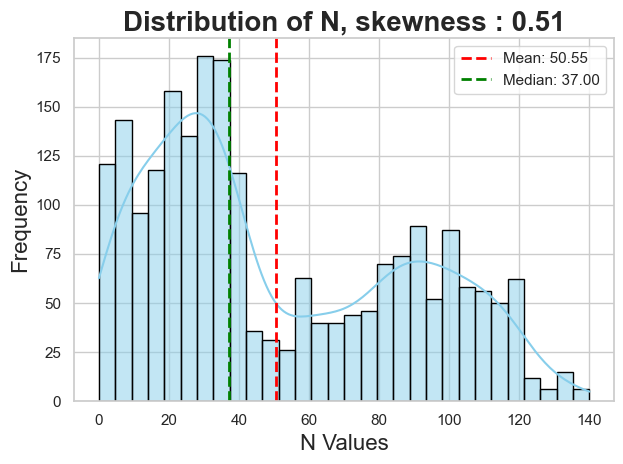

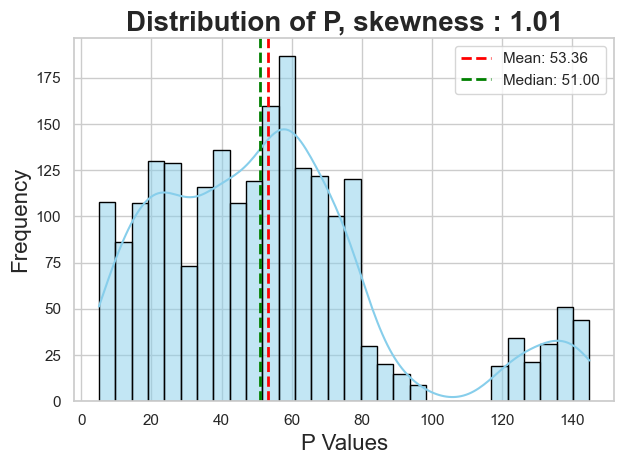

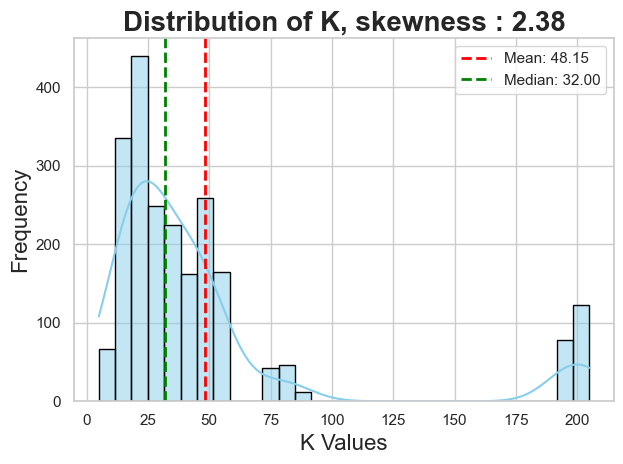

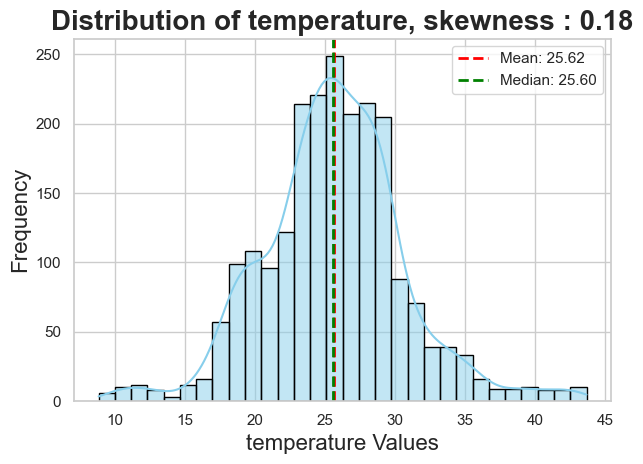

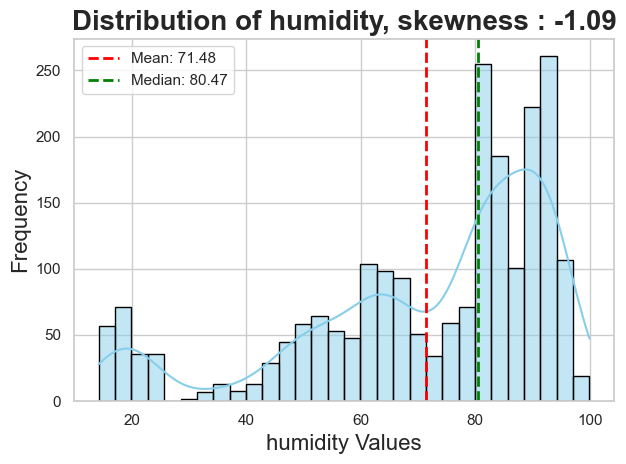

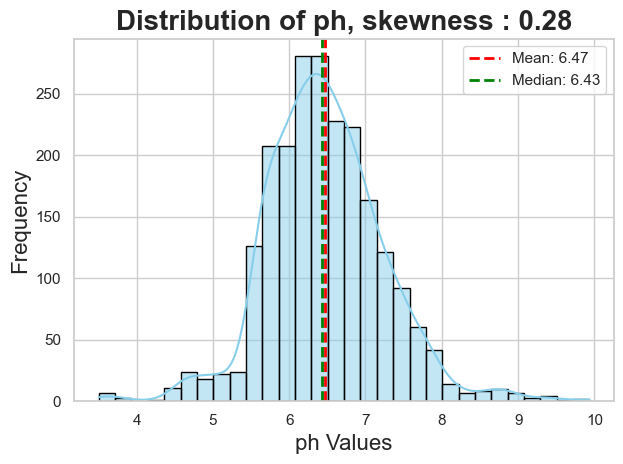

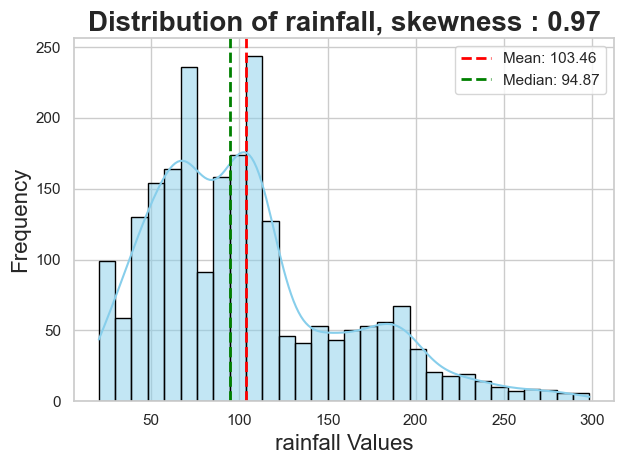

In [12]:
for cols in data.select_dtypes(include=['int32', 'int64', 'float32', 'float64']).columns:
    ax = sns.histplot(
        data=data,
        x=cols,
        bins=30,            
        kde=True,          
        color='skyblue',    
        edgecolor='black' 
    )
    
    skew_val = data[cols].skew()
    ax.set_title(f'Distribution of {cols}, skewness : {skew_val:.2f}', fontsize=20, fontweight='bold')
    ax.set_xlabel(f'{cols} Values', fontsize=16)
    ax.set_ylabel('Frequency', fontsize=16)
    
    mean_val = data[cols].mean()
    median_val = data[cols].median()
    
    plt.axvline(mean_val, color='red', linestyle='dashed', linewidth=2,
                label=f'Mean: {mean_val:.2f}')
    plt.axvline(median_val, color='green', linestyle='dashed', linewidth=2,
                label=f'Median: {median_val:.2f}')


    plt.legend()
    plt.tight_layout()
    plt.show()

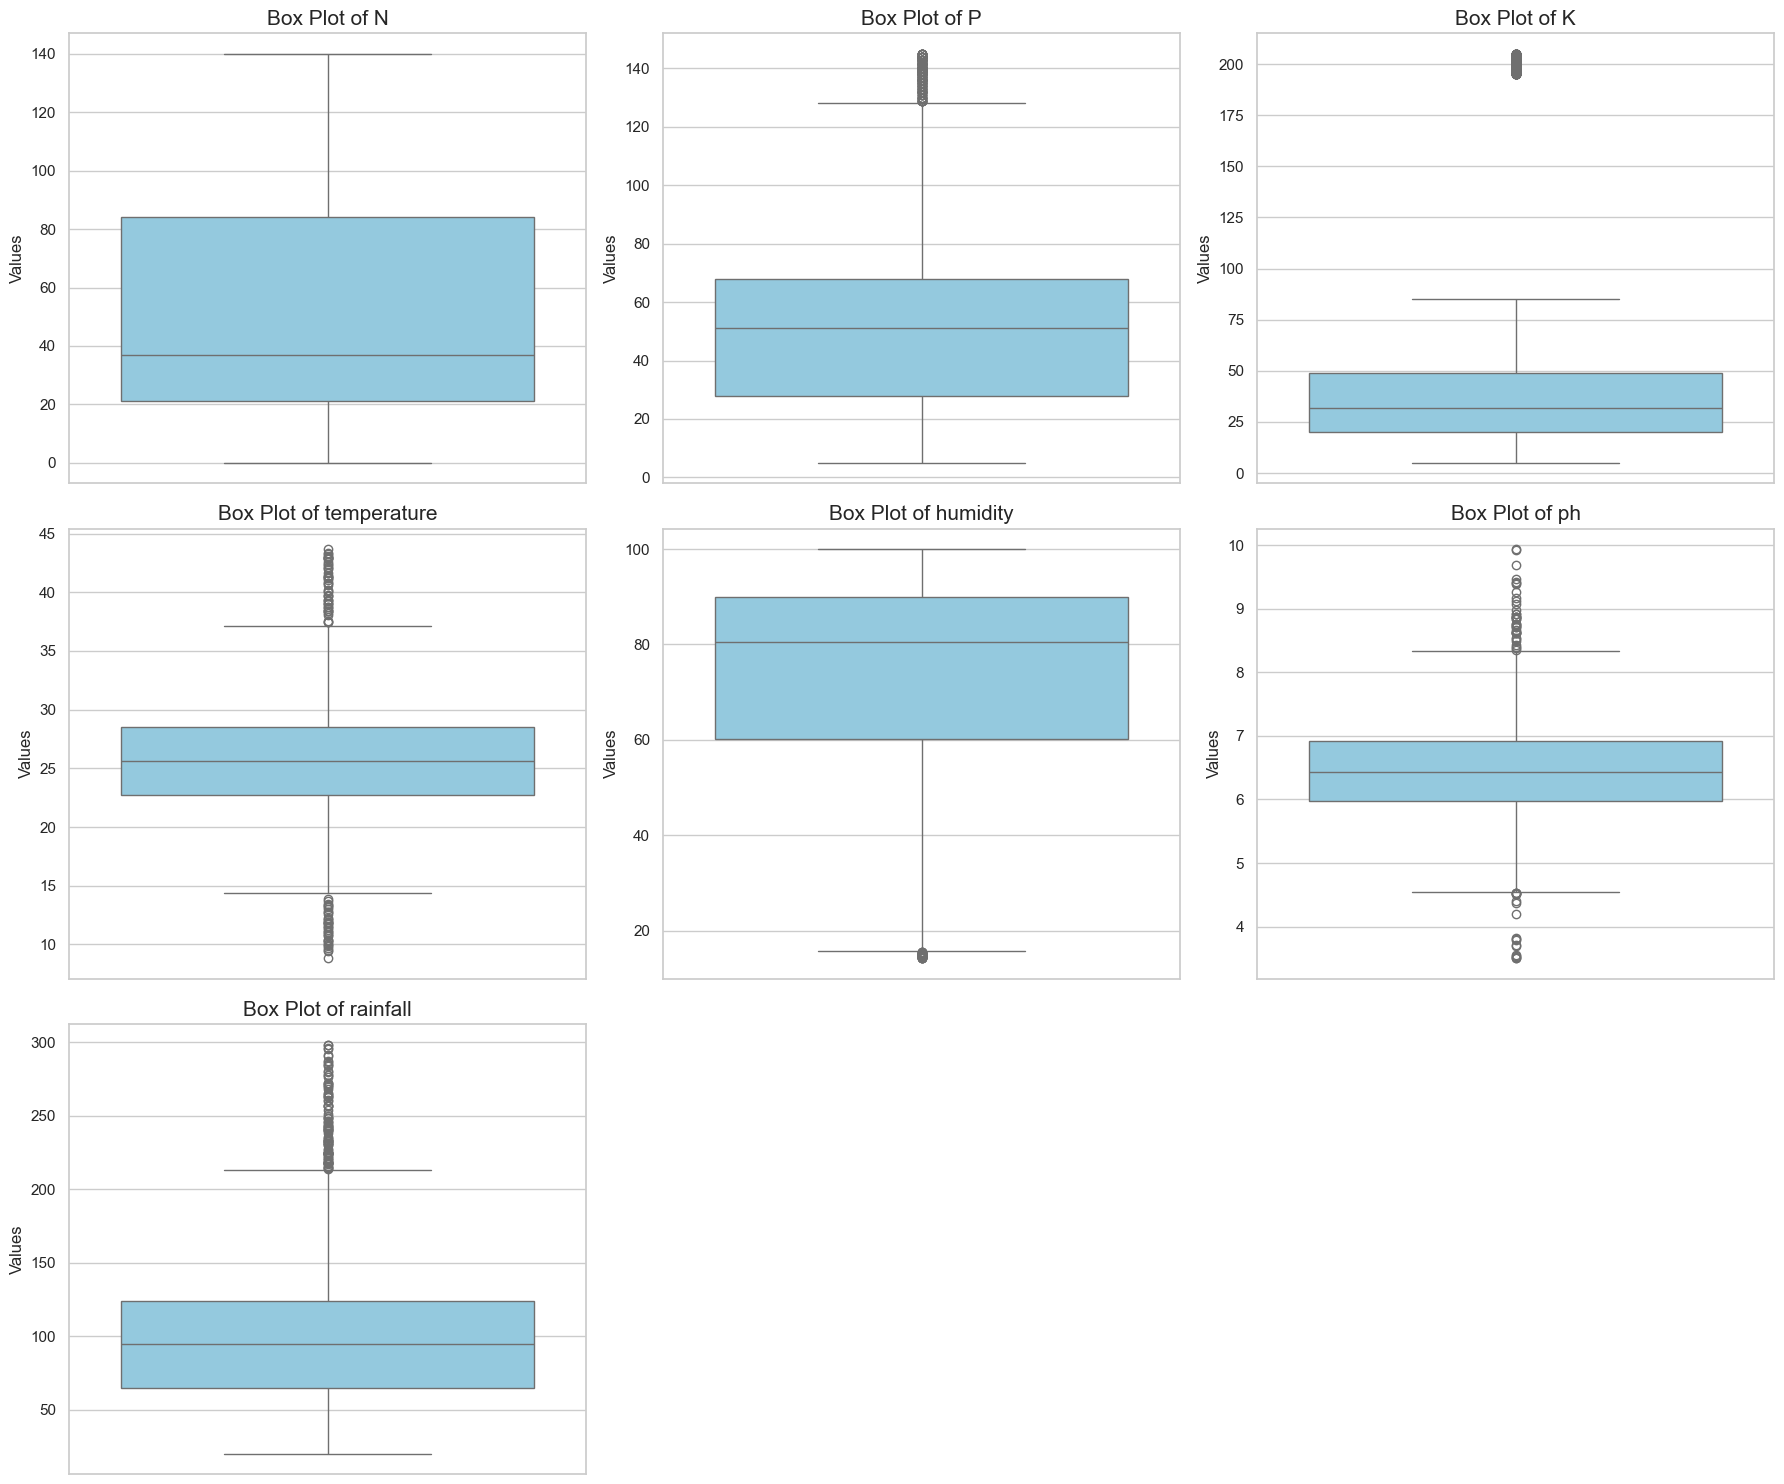

In [13]:
numeric_columns = data.select_dtypes(include=['int32', 'int64', 'float32', 'float64']).columns

num_cols = len(numeric_columns)
cols_per_row = 3 
rows = (num_cols // cols_per_row) + (num_cols % cols_per_row > 0) 

fig, axes = plt.subplots(rows, cols_per_row, figsize=(18, rows * 5))

axes = axes.flatten()

for i, col in enumerate(numeric_columns):
    sns.boxplot(y=data[col], ax=axes[i], color="skyblue")
    axes[i].set_title(f'Box Plot of {col}', fontsize=15)
    axes[i].set_ylabel('Values')

# Hide unused subplots (if num_cols is not a multiple of cols_per_row)
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

In [14]:
outlier_data = outlier_percentage(data)
outlier_df = pd.DataFrame.from_dict(outlier_data, orient='index', columns=['Outlier Percentage'])
outlier_df.reset_index(inplace=True)
outlier_df.rename(columns={'index': 'Column Name'}, inplace=True)
print(tabulate(outlier_df, headers='keys', tablefmt='grid'))

+----+---------------+----------------------+
|    | Column Name   |   Outlier Percentage |
+====+===============+======================+
|  0 | K             |                 9.09 |
+----+---------------+----------------------+
|  1 | P             |                 6.27 |
+----+---------------+----------------------+
|  2 | rainfall      |                 4.55 |
+----+---------------+----------------------+
|  3 | temperature   |                 3.91 |
+----+---------------+----------------------+
|  4 | ph            |                 2.59 |
+----+---------------+----------------------+
|  5 | humidity      |                 1.36 |
+----+---------------+----------------------+
|  6 | N             |                 0    |
+----+---------------+----------------------+


In [15]:
outlier_percentage(data)

{'K': 9.09,
 'P': 6.27,
 'rainfall': 4.55,
 'temperature': 3.91,
 'ph': 2.59,
 'humidity': 1.36,
 'N': 0.0}

In [16]:
possible_log_transform = ['P', 'K', 'humidity', 'rainfall']

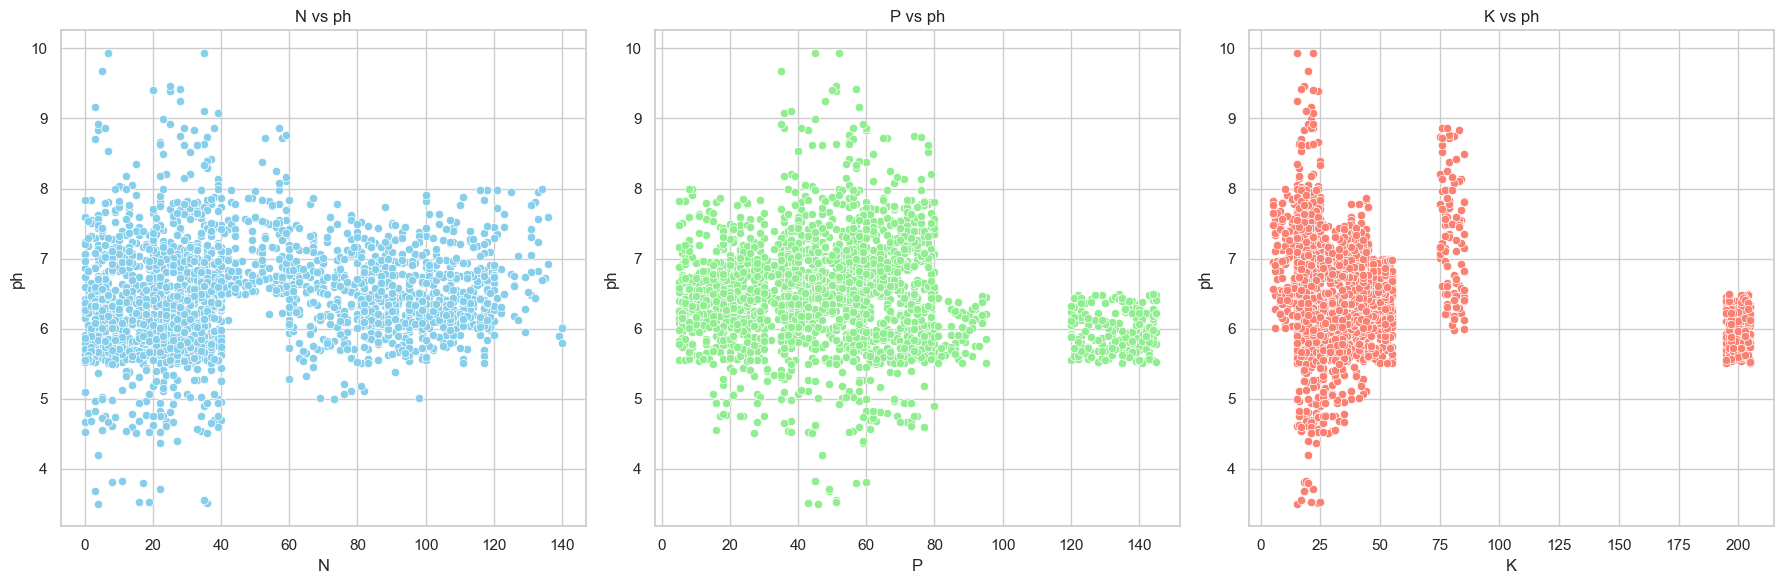

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.scatterplot(x=data['N'], y=data['ph'], ax=axes[0], color='skyblue')
axes[0].set_title("N vs ph")
axes[0].set_xlabel("N")
axes[0].set_ylabel("ph")

sns.scatterplot(x=data['P'], y=data['ph'], ax=axes[1], color='lightgreen')
axes[1].set_title("P vs ph")
axes[1].set_xlabel("P")
axes[1].set_ylabel("ph")

sns.scatterplot(x=data['K'], y=data['ph'], ax=axes[2], color='salmon')
axes[2].set_title("K vs ph")
axes[2].set_xlabel("K")
axes[2].set_ylabel("ph")

plt.tight_layout()
plt.show()

In [18]:
data

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice
...,...,...,...,...,...,...,...,...
2195,107,34,32,26.774637,66.413269,6.780064,177.774507,coffee
2196,99,15,27,27.417112,56.636362,6.086922,127.924610,coffee
2197,118,33,30,24.131797,67.225123,6.362608,173.322839,coffee
2198,117,32,34,26.272418,52.127394,6.758793,127.175293,coffee


In [19]:
N_grouped = data.groupby('label')['N'].median().reset_index()
P_grouped = data.groupby('label')['P'].median().reset_index()
K_grouped = data.groupby('label')['K'].median().reset_index()
ph_grouped = data.groupby('label')['ph'].median().reset_index()
Temp_grouped = data.groupby('label')['temperature'].median().reset_index()
Hum_grouped = data.groupby('label')['humidity'].median().reset_index()
Rain_grouped = data.groupby('label')['rainfall'].median().reset_index()
merged_df = N_grouped.merge(P_grouped, on='label').merge(K_grouped, on='label').merge(Temp_grouped, on='label').merge(Hum_grouped, on='label').merge(Rain_grouped, on='label').merge(ph_grouped, on='label').round(2)

In [20]:
merged_df

,label,N,P,K,temperature,humidity,rainfall,ph
0,apple,24.0,136.5,200.0,22.63,92.42,112.98,5.89
1,banana,100.5,81.0,50.0,27.44,80.22,105.01,5.99
2,blackgram,41.0,67.0,19.0,29.66,65.03,68.29,7.17
3,chickpea,39.0,68.0,79.0,18.88,16.66,79.69,7.36
4,coconut,24.0,15.5,31.0,27.39,94.96,172.00,5.99
5,coffee,103.0,29.0,30.0,25.66,57.65,157.77,6.80
6,cotton,117.0,46.0,19.0,23.96,80.01,80.24,6.84
7,grapes,24.0,133.0,201.0,23.02,81.72,69.54,6.00
8,jute,78.0,46.0,40.0,24.97,79.47,175.59,6.71
9,kidneybeans,22.0,67.0,20.0,19.92,21.35,107.40,5.75


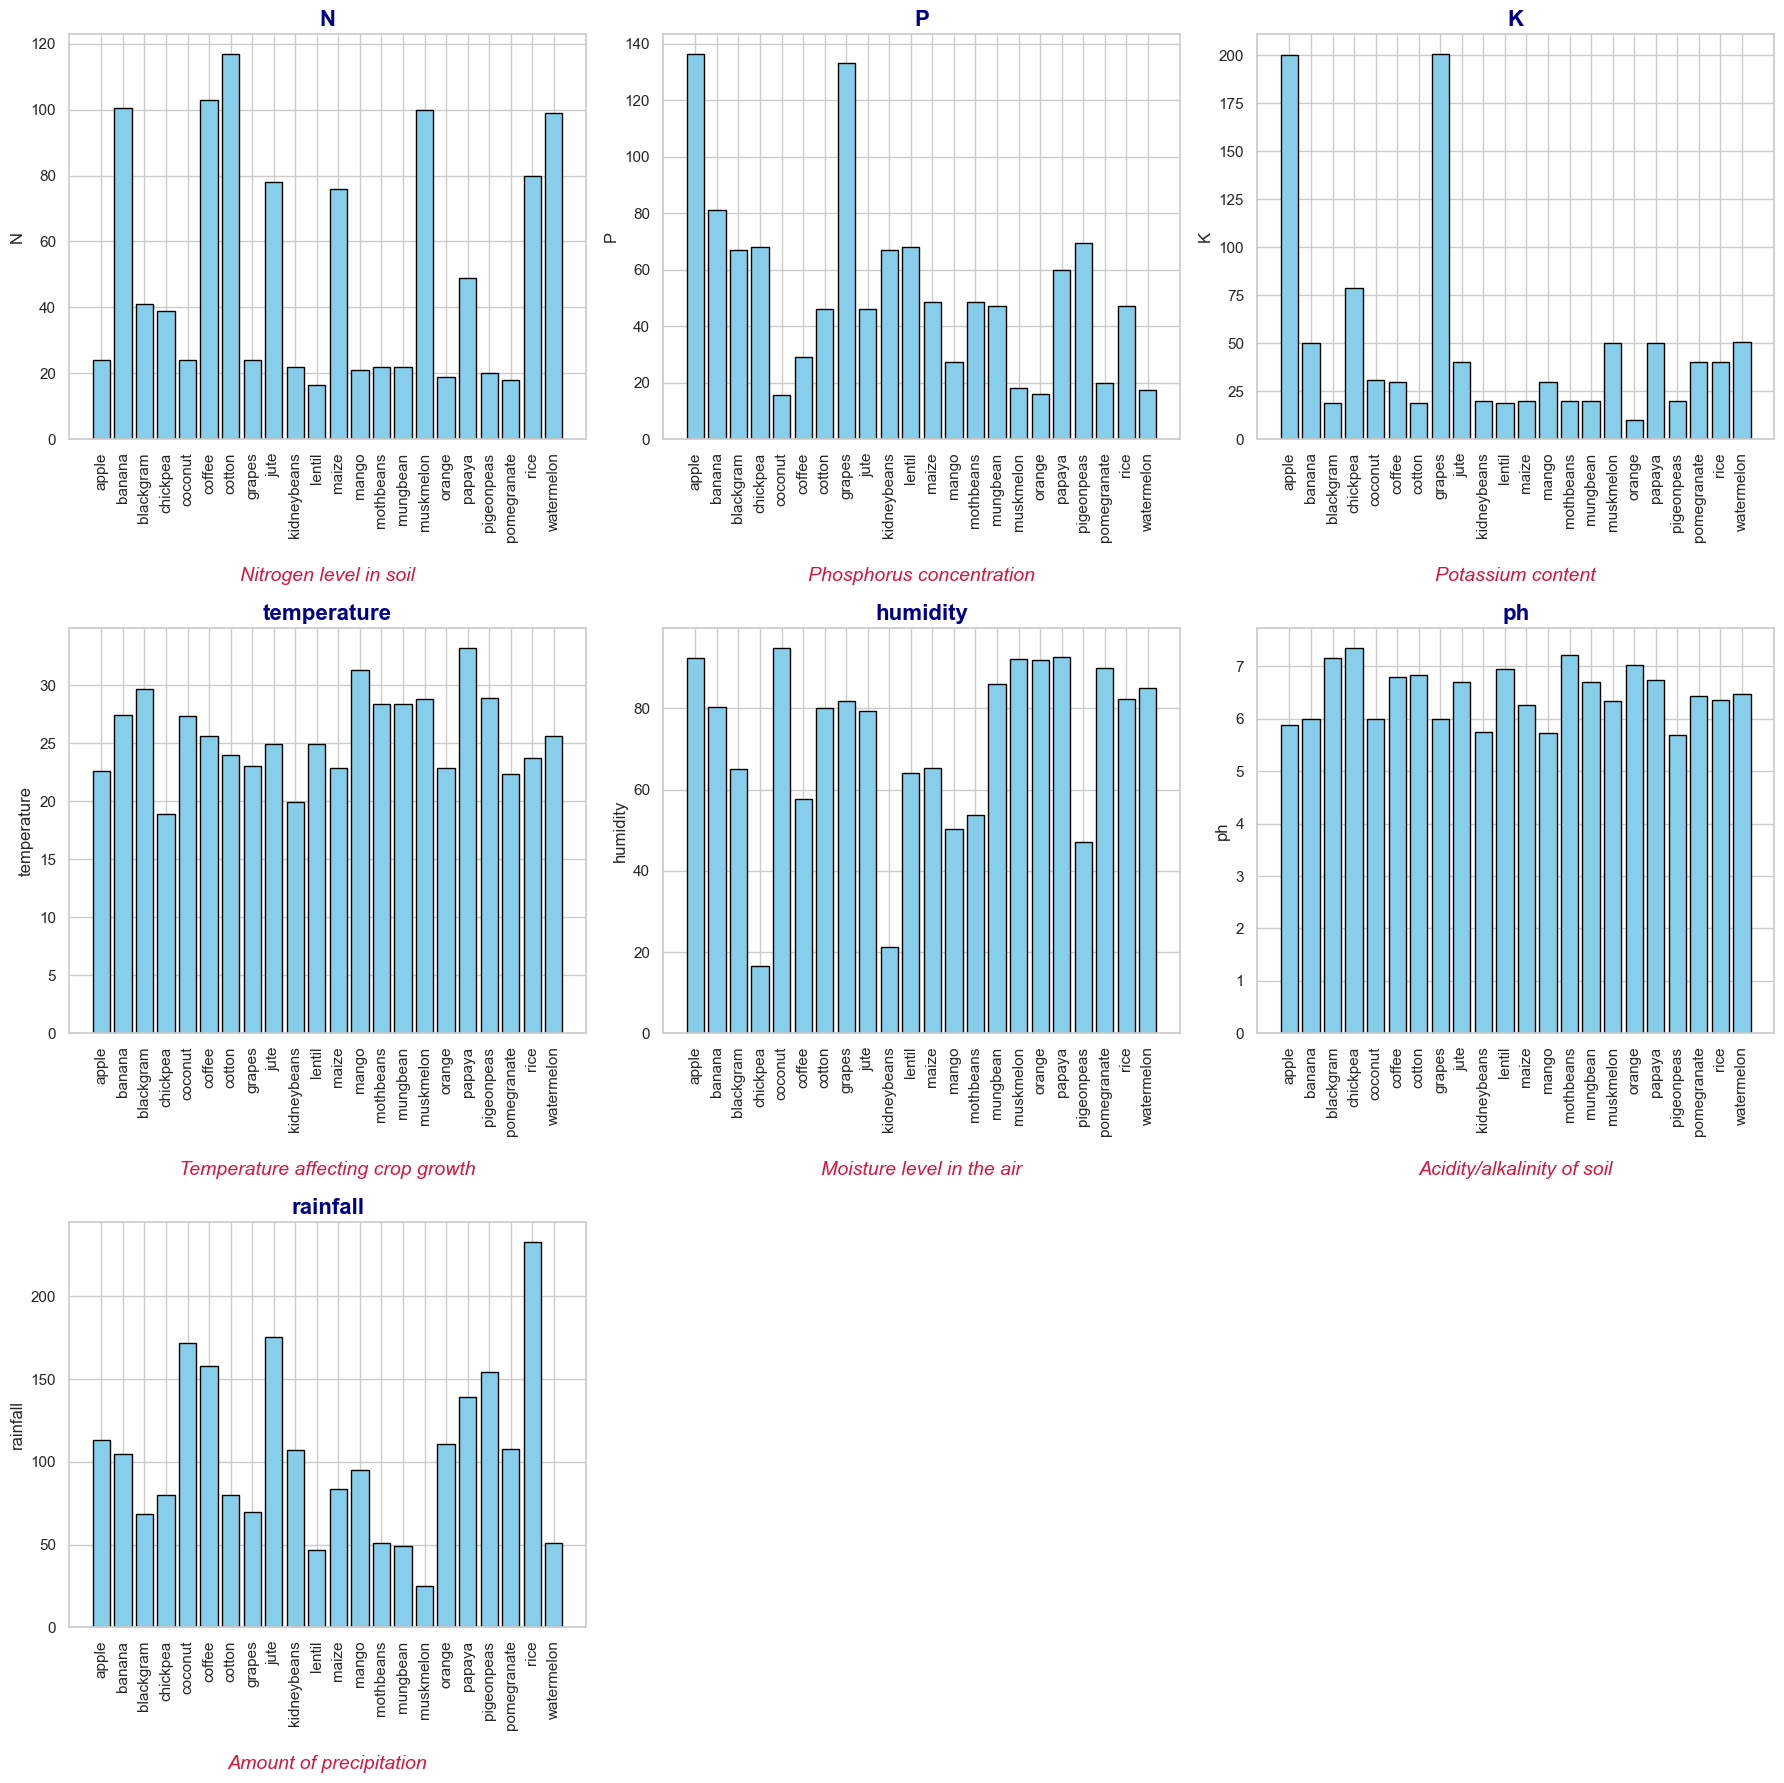

In [21]:
columns_to_plot = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
column_descriptions = {
    'N': "Nitrogen level in soil",
    'P': "Phosphorus concentration",
    'K': "Potassium content",
    'temperature': "Temperature affecting crop growth",
    'humidity': "Moisture level in the air",
    'ph': "Acidity/alkalinity of soil",
    'rainfall': "Amount of precipitation"
}

# Calculate grid layout (3 plots per row)
cols_per_row = 3
num_rows = -(-len(columns_to_plot) // cols_per_row)  # Ceiling division

# Create a subplot grid layout
fig, axes = plt.subplots(num_rows, cols_per_row, figsize=(18, num_rows * 6))

# Flatten axes for easy iteration
axes = axes.flatten()

# Loop through columns and plot bar graphs with enhanced titles & descriptions
for i, col in enumerate(columns_to_plot):
    axes[i].bar(merged_df['label'], merged_df[col], color='skyblue', edgecolor='black')
    
    # 🔹 **Bold Titles with Larger Font**
    axes[i].set_title(f"{col}", fontsize=16, fontweight="bold", color="darkblue")
    
    # 📌 *Italic & Colored Descriptions*
    axes[i].text(
        0.5, -0.35, column_descriptions[col], 
        fontsize=14, ha='center', transform=axes[i].transAxes, color="crimson", style="italic"
    )

    axes[i].set_ylabel(col)
    axes[i].tick_params(axis='x', rotation=90)

# Hide unused subplots (if any)
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

# Adjust layout for spacing
plt.tight_layout()
plt.show()

---
# **Feature Scaling + Model Training**

In [28]:
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

In [32]:
results = {}

In [42]:
params_grid = {
    'Logistic Regression' : {
        'model__C' : [0.1, 1, 10] 
    },
    'Random Forest' : {
        'model__n_estimators' : [100, 200],
        'model__max_depth' : [None, 10, 20]
    },
    'SVM' : {
        'model__C' : [0.1, 1, 10],
        'model__kernel' : ['linear', 'rbf']
    },
    'KNN' : {
        'model__n_neighbors' : [3, 5, 7]
    }
}

In [43]:
model_line = {
    
    'Logistic Regression' : Pipeline([
        ('scaler', StandardScaler()),
        ('model', LogisticRegression(max_iter=1000))
    ]),
    
    'Random Forest' : Pipeline([
        ('model', RandomForestClassifier(random_state=42))
    ]),
    
    'SVM' : Pipeline([
        ('scaler', StandardScaler()),
        ('model', SVC(probability=True, random_state=42))
    ]),

    'KNN' : Pipeline([
        ('scaler', StandardScaler()),
        ('model', KNeighborsClassifier())
    ])
}

In [47]:
for model_name, process_line in model_line.items():
    print(f"Training.....{model_name}")

    cv = GridSearchCV(
        estimator = process_line,
        param_grid = params_grid[model_name],
        cv = 5,
        scoring = 'accuracy',
        n_jobs = -1,
        verbose = 1
    )

    cv.fit(x_train, y_train_encoded)

    best_model = cv.best_estimator_

    y_pred = best_model.predict(x_test)
    accuracy = accuracy_score(y_test_encoded, y_pred)

    results[model_name] = {
        'accuracy' : accuracy,
        'best_params' : cv.best_params_,
        'cv_result' : cv.cv_results_,
        'model' : best_model,
        'classification_report' : classification_report(y_test_encoded, y_pred)
    }

    print(f"\t👉{model_name}, test accuracy : {accuracy:.4f}")
    print(f"\t👉Best parametters, {cv.best_params_}")
    print(f"\t👉Classifcation report")
    print(f"\t{results[model_name]['classification_report']}")

Training.....Logistic Regression
Fitting 5 folds for each of 3 candidates, totalling 15 fits
	👉Logistic Regression, test accuracy : 0.9886
	👉Best parametters, {'model__C': 10}
	👉Classifcation report
	              precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00        15
           2       0.94      1.00      0.97        16
           3       1.00      1.00      1.00        18
           4       1.00      1.00      1.00        19
           5       1.00      1.00      1.00        22
           6       0.96      1.00      0.98        23
           7       1.00      1.00      1.00        20
           8       0.92      1.00      0.96        23
           9       1.00      1.00      1.00        20
          10       1.00      1.00      1.00        31
          11       1.00      0.94      0.97        17
          12       1.00      1.00      1.00        13
          13       1.00      0.95      0.97

In [49]:
best_performer = max(results, key=lambda x : results[x]['accuracy'])

In [50]:
print(f"Best performer : {best_performer}, with accuracy : {results[best_performer]['accuracy']:.4f}")

Best performer : SVM, with accuracy : 0.9932
